In [37]:
import os
import gc
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm, trange
import time
try:
   import cPickle as pickle
except:
   import pickle
#from celluloid import Camera
from IPython.display import HTML

import copy
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn import preprocessing
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

%matplotlib inline
#uncomment if using Google Colab instead of Kaggle or local storage
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#DATA PREPROCESSING ==> Only used once. Afterwards, the data is saved in a Pickle file 

directory = r'/content/drive/MyDrive/Colab Notebooks/data/Tatiana_Niembro_100919_1_data_218705022831'
dir = os.listdir(directory)
dir.sort()

def gen(directory, filename):
    df = pd.read_csv(os.path.join(directory, filename), delim_whitespace=True, skiprows=8)
    df.columns=df.columns+df.loc[0]
    df.columns = np.append(df.columns.values[1:], 'x')
    df=df.drop('x', axis=1)
    df=df.drop([0]).fillna(0)
    df = df.astype(float)
    df=df.drop('yR_E', axis=1)
    df=df.sort_values(by=['zR_E', 'xR_E'], ascending=[False, True])
    return df
i=0
dataset_deep = []
for filename in tqdm(dir[50:650]):
    #if filename.endswith(".txt"):
    dataset_deep.append(gen(directory, filename))
    #else:
    #    continue

df = dataset_deep[0]
for column in df:
    print(column)

In [ ]:
#SAVING A PICKLE FILE
outfile = open('/content/drive/MyDrive/Colab Notebooks/data/test','wb')
pickle.dump(dataset_deep,outfile)
outfile.close()

In [10]:
#OPENING PICKLE DATASET + LOOKING AT SHAPE OF 1ST DATAFRAME
infile = open('/kaggle/input/openggcm-pickle/50-650frames','rb')
df = pickle.load(infile)
infile.close()
columns = df[0].drop('EtaVm/A', 1).columns[2:] #get names of columns I will use
print(len(df))
print(df[0].shape)
print(columns)

600
(40401, 17)
Index(['B_xnT', 'B_ynT', 'B_znT', 'V_xkm/s', 'V_ykm/s', 'V_zkm/s', 'Ncm^-3',
       'PnPa', 'eflx[]', 'efly[]', 'eflz[]', 'J_xmuA/m^2', 'J_ymuA/m^2',
       'J_zmuA/m^2'],
      dtype='object')


Uncomment the variable that is to be used

In [116]:
#labels = ['B_xnT', 'B_ynT', 'B_znT']              #Magnetic Field
#labels = ['V_xkm/s', 'V_ykm/s', 'V_zkm/s']        #Velocity
#labels = ['Ncm^-3']                               #Density 
labels = ['PnPa']                                 #Pressure
#labels = ['eflx[]', 'efly[]', 'eflz[]']           #Flux
#labels = ['J_xmuA/m^2', 'J_ymuA/m^2','J_zmuA/m^2'] #Current density
uselog = False #Enable if you want to use the log of the values. Only use with density or pressure
use_avg = True
print("Labels used: ", labels, "\nUsing the log?: ", uselog, "\nUsing average?: ", use_avg)

Labels used:  ['PnPa'] 
Using the log?:  False 
Using average?:  True


In [117]:
n_channels_default = len(labels)
print("Channels: ", n_channels_default)
from numpy import inf
dfx = np.zeros([600, n_channels_default, 200, 200])
i=0
for frame in df:
  j=0
  #frame = frame[['B_xnT', 'B_ynT', 'B_znT']].clip(-100,100)
  #frame = frame[['V_xkm/s', 'V_ykm/s', 'V_zkm/s']].clip(-100,100)
  #rame = frame[['eflx[]', 'efly[]', 'eflz[]']].clip(-100,100)
  frame = frame[labels]#.clip(-100,100)
  for col in frame:
    arr = np.array(frame[col].values.reshape(-1, 1).astype(np.float64)).reshape(201,201)
    if uselog:
        arr = no.log(arr)
    arr = np.delete(arr, 200, 1)
    arr = np.delete(arr, 200, 0)
    dfx[i][j] = arr
    j+=1
  i+=1
print("data shape: ", dfx.shape)

#AVERAGE
if use_avg:
    average = np.average(dfx, axis=0)
    print("shape of the average frame: ", average.shape) # should be (n_channels_default, 200, 200)
    for i in range(len(dfx)):
      dfx[i] = dfx[i] - average

Channels:  1
data shape:  (600, 1, 200, 200)
shape of the average frame:  (1, 200, 200)


In [118]:
dataset = copy.deepcopy(dfx)
np.random.shuffle(dataset)
cuda0 = torch.device('cuda:0')
dataset = torch.tensor(dataset[:600], device=cuda0)
#dataset = dataset.unsqueeze(-1)
np.random.shuffle(dataset)
train_data = dataset[:400]
validation_data = dataset[400:500]
test_data = dataset[500:600]

In [119]:
torch.manual_seed(42)  # for consistent results

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [120]:
cuda0 = torch.device('cuda:0')
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = nn.Conv2d(n_channels_default, n_channels_default, 4, 1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(n_channels_default)
        self.pool1 = nn.MaxPool2d(4, 2, 1)
        self.encoder2 = nn.Conv2d(n_channels_default, n_channels_default, 4, 1, padding=1)
        self.pool2 = nn.MaxPool2d(4, 2, 1)
        self.batchnorm2 = nn.BatchNorm2d(n_channels_default)
        self.linear_encoder1 = nn.Linear(2401*n_channels_default, 1200*n_channels_default)
        self.linear_encoder2 = nn.Linear(1200*n_channels_default, 600*n_channels_default)
    def forward(self, X):
      X = F.leaky_relu(self.encoder1(X))
      X = self.batchnorm1(X)
      X = self.pool1(X)
      X = F.leaky_relu(self.encoder2(X))
      X = self.batchnorm2(X)
      X = self.pool2(X)
      X = torch.flatten(X)
      X = F.leaky_relu(self.linear_encoder1(X))
      X = F.leaky_relu(self.linear_encoder2(X))
      return X

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_decoder1 = nn.Linear(600*n_channels_default, 1200*n_channels_default)
        self.linear_decoder2 = nn.Linear(1200*n_channels_default, 2401*n_channels_default)
        self.decoder1 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 2, padding=0)
        self.decoder2 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 2, padding=0)
        self.decoder3 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 1, padding=0)
        self.decoder4 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 4, 1, padding=0)
    def forward(self, X):
      X = F.leaky_relu(self.linear_decoder1(X))
      X = F.leaky_relu(self.linear_decoder2(X))
      X = torch.reshape(X, (1, n_channels_default, 49, 49))
      X = F.leaky_relu(self.decoder1(X))
      X = F.leaky_relu(self.decoder2(X))
      X = F.leaky_relu(self.decoder3(X))
      X = self.decoder4(X)
      return X

class AE(nn.Module):
    def __init__(self, encoder_module, decoder_module):
        super().__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
    def forward(self, X):
        encoded = self.encoder(X)
        return self.decoder(encoded)

encoder_model = Encoder().to(cuda0)
decoder_model = Decoder().to(cuda0)
model = AE(encoder_model, decoder_model)
model.to(cuda0)

print(model)
criterion = nn.MSELoss()

AE(
  (encoder): Encoder(
    (encoder1): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder2): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batchnorm2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_encoder1): Linear(in_features=2401, out_features=1200, bias=True)
    (linear_encoder2): Linear(in_features=1200, out_features=600, bias=True)
  )
  (decoder): Decoder(
    (linear_decoder1): Linear(in_features=600, out_features=1200, bias=True)
    (linear_decoder2): Linear(in_features=1200, out_features=2401, bias=True)
    (decoder1): ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=(2, 2))
    (decoder2): ConvTranspose2d(1, 

In [52]:
if False:#set to True to use this model
    cuda0 = torch.device('cuda:0')
    class AE(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder1 = nn.Conv2d(n_channels_default, n_channels_default, 4, 1, padding=1)
            self.pool1 = nn.MaxPool2d(4, 2, 1)
            self.encoder2 = nn.Conv2d(n_channels_default, n_channels_default, 4, 1, padding=1)
            self.pool2 = nn.MaxPool2d(4, 2, 1)
            self.linear_encoder1 = nn.Linear(7203, 3600)
            self.linear_encoder2 = nn.Linear(3600, 1800)
            self.linear_decoder1 = nn.Linear(1800, 3600)
            self.linear_decoder2 = nn.Linear(3600, 7203)
            self.decoder1 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 2, padding=0)
            self.decoder2 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 2, padding=0)
            self.decoder3 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 1, padding=0)
            self.decoder4 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 4, 1, padding=0)

        def forward(self, X):
          X = F.leaky_relu(self.encoder1(X))
          X = self.pool1(X)
          X = F.leaky_relu(self.encoder2(X))
          X = self.pool2(X)
          X = torch.flatten(X)
          X = F.leaky_relu(self.linear_encoder1(X))
          X = F.leaky_relu(self.linear_encoder2(X))
          X = F.leaky_relu(self.linear_decoder1(X))
          X = F.leaky_relu(self.linear_decoder2(X))
          X = torch.reshape(X, (1, 3, 49, 49))
          X = F.leaky_relu(self.decoder1(X))
          X = F.leaky_relu(self.decoder2(X))
          X = F.leaky_relu(self.decoder3(X))
          X = self.decoder4(X)
          return X

    model = AE()
    model.to(cuda0)
    print(model)
    #Loss function
    criterion = nn.MSELoss()

    #Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
if False:#set to True to use this model
    cuda0 = torch.device('cuda:0')
    class AE(nn.Module):
        def __init__(self):
            super().__init__()
            n_channels_default = 3
            #self.bn1 = nn.BatchNorm2d(14, 30, 200, 200)
            self.encoder1 = nn.Conv2d(n_channels_default, n_channels_default, 4, 1, padding=1)
            self.batchnorm1 = nn.BatchNorm2d(n_channels_default)
            self.encoder2 = nn.Conv2d(n_channels_default, n_channels_default, 4, 1, padding=1)
            self.batchnorm2 = nn.BatchNorm2d(n_channels_default)
            self.encoder3 = nn.Conv2d(n_channels_default, n_channels_default, 2, 2, padding=0)
            self.batchnorm3 = nn.BatchNorm2d(n_channels_default)
            self.encoder4 = nn.Conv2d(n_channels_default, n_channels_default, 2, 2, padding=0)
            self.batchnorm4 = nn.BatchNorm2d(n_channels_default)
            #self.encoder5 = nn.Conv2d(n_channels_default, n_channels_default, 2, 1, padding=0)
            #self.encoder6 = nn.Conv2d(n_channels_default, n_channels_default, 2, 1, padding=0)
            self.linear_encoder1 = nn.Linear(7203, 3600)
            self.linear_encoder2 = nn.Linear(3600, 1800)
            self.linear_decoder1 = nn.Linear(1800, 3600)
            self.linear_decoder2 = nn.Linear(3600, 7203)
            #self.decoder1 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 1, padding=0)
            #self.decoder2 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 1, padding=0)
            self.decoder1 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 2, padding=0)
            #self.batchnorm5 = nn.BatchNorm2d(1)
            self.decoder2 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 2, padding=0)
            #self.batchnorm6 = nn.BatchNorm2d(1)
            self.decoder3 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 2, 1, padding=0)
            #self.batchnorm7 = nn.BatchNorm2d(1)
            self.decoder4 = nn.ConvTranspose2d(n_channels_default, n_channels_default, 4, 1, padding=0)
            #self.batchnorm8 = nn.BatchNorm2d(1)

        def forward(self, X):
          X = F.leaky_relu(self.encoder1(X))
          X = self.batchnorm1(X)
          X = F.leaky_relu(self.encoder2(X))
          X = self.batchnorm2(X)
          X = F.leaky_relu(self.encoder3(X))
          X = self.batchnorm3(X)
          X = F.leaky_relu(self.encoder4(X))
          X = self.batchnorm4(X)
          X = torch.flatten(X)
          X = F.leaky_relu(self.linear_encoder1(X))
          X = F.leaky_relu(self.linear_encoder2(X))
          X = F.leaky_relu(self.linear_decoder1(X))
          X = F.leaky_relu(self.linear_decoder2(X))
          X = torch.reshape(X, (1, 3, 49, 49))
          X = F.leaky_relu(self.decoder1(X))
          X = F.leaky_relu(self.decoder2(X))
          X = F.leaky_relu(self.decoder3(X))
          X = self.decoder4(X)
          return X

    model = AE()
    model.to(cuda0)
    print(model)
    #Loss function
    criterion = nn.MSELoss()
    block
    #Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 8.6714418223 	Validation Loss: 0.0311367798 	Learning Rate: 0.010000
Epoch: 10 	Training Loss: 0.0253010655 	Validation Loss: 0.0179975319 	Learning Rate: 0.010000
Epoch: 20 	Training Loss: 0.0248276119 	Validation Loss: 0.0178738100 	Learning Rate: 0.010000
Epoch: 30 	Training Loss: 0.0246381533 	Validation Loss: 0.0191907883 	Learning Rate: 0.010000
Epoch: 40 	Training Loss: 0.0241777118 	Validation Loss: 0.0174544673 	Learning Rate: 0.010000
Epoch: 50 	Training Loss: 0.0240025713 	Validation Loss: 0.0181913361 	Learning Rate: 0.010000
Epoch: 60 	Training Loss: 0.0234933723 	Validation Loss: 0.0173469539 	Learning Rate: 0.001000
Epoch: 70 	Training Loss: 0.0234689485 	Validation Loss: 0.0172813271 	Learning Rate: 0.001000
Epoch: 80 	Training Loss: 0.0234513299 	Validation Loss: 0.0172792602 	Learning Rate: 0.001000
Epoch: 90 	Training Loss: 0.0234330837 	Validation Loss: 0.0172546558 	Learning Rate: 0.001000
Epoch: 100 	Training Loss: 0.0234257015 	Validation

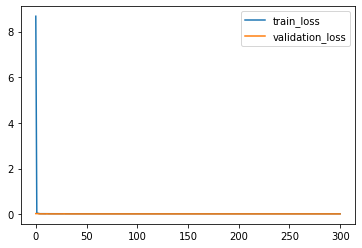

In [121]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#TRAINING THE MODEL
loss_values = []
v_loss_values = []
n_epochs = 300
#torch.autograd.set_detect_anomaly(True)
for epoch in tqdm(range(0, n_epochs+1)):
    if(50 > epoch):
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
      lr=0.01
    elif(150 > epoch > 50):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        lr=0.001
    elif(250 > epoch > 150):
      optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
      lr=0.0001
    elif(300 > epoch > 250):
      optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
      lr=0.00001
    elif(epoch > 700):
      optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
      lr=0.000001
    # monitor training loss
    train_loss = 0.0
    validation_loss = 0.0
    for data in enumerate(train_loader):
        data = data[1]
        images = data
        optimizer.zero_grad()
        outputs = model(data.float())
        loss = criterion(outputs.float(), images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    for data in enumerate(validation_loader):
        data = data[1]
        images = data
        outputs = model(data.float())
        loss = criterion(outputs.float(), images.float())
        validation_loss += loss.item()*images.size(0)
    validation_loss = validation_loss/len(validation_loader)
    if(epoch % 10 == 0):
      print('Epoch: {} \tTraining Loss: {:.10f} \tValidation Loss: {:.10f} \tLearning Rate: {:.6f}'.format(epoch, train_loss, validation_loss, lr))
    loss_values.append(train_loss)
    v_loss_values.append(validation_loss)
    

plt.plot(loss_values,  label="train_loss")
plt.plot(v_loss_values,  label="validation_loss")
plt.legend(loc="upper right")
plt.show()

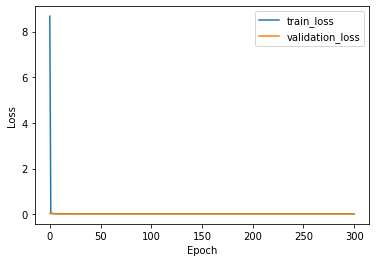

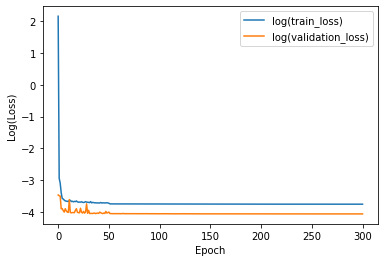

In [122]:
plt.plot(loss_values,  label="train_loss")
plt.plot(v_loss_values,  label="validation_loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.plot(np.log(loss_values), label="log(train_loss)")
plt.plot(np.log(v_loss_values),  label="log(validation_loss)")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")
plt.show()

In [ ]:
#SAVING MODEL (after run)
#outfile = open('/content/drive/MyDrive/Colab Notebooks/data/3channel_B_pooling_batchnorm_2encoderlin','wb')
outfile = open('/kaggle/output/kaggle/working/3channel_flux_batchnorm_encoder_only','wb')
pickle.dump(model,outfile)
outfile.close()

In [ ]:
#OPENING MODEL, so I don't need to rerun it every time
infile = open('/content/drive/MyDrive/Colab Notebooks/data/3channel_B_pooling_batchnorm_2encoderlin','rb')
model = pickle.load(infile)
infile.close()
print(model)

In [125]:
dataiter = iter(test_loader)

Reconstructed: 


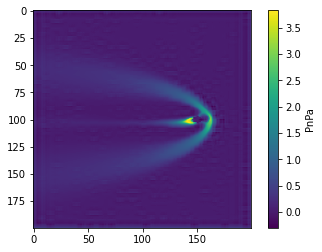

Original: 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


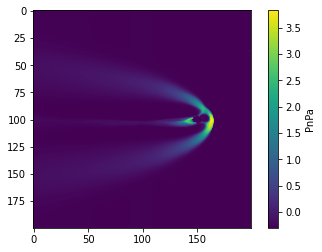

Mean RMSE:  0.12584063886499408
Mean PSNR:  67.50154446638065
Mean SSIM:  0.7972800650019206


In [126]:
dataiter = iter(test_loader)
images = dataiter.next()

if use_avg:
    output = model(images.float()) #.double()
    images = images.cpu().numpy() + average
    output = output.view(1, n_channels_default, 200, 200)
    output = output.cpu().detach().numpy() + average
else:
    output = model(images.float()) #.double()
    images = images.cpu().numpy()
    output = output.view(1, n_channels_default, 200, 200)
    output = output.cpu().detach().numpy()

for i in range(n_channels_default):
    print("Reconstructed: ")
    fig1 = plt.imshow(output[0][i].squeeze())
    cbar = plt.colorbar(fig1)
    cbar.set_label(labels[i])
    plt.show()
    print("Original: ")
    fig = plt.imshow(images[0][i].squeeze())
    cbar = plt.colorbar(fig1)
    cbar.set_label(labels[i])
    plt.show()

def rmse(predictions, targets):
    return np.sqrt(np.average((predictions - targets) ** 2))
#source: https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python

dataiter = iter(test_loader)
rmse_sum = []
for _ in range(len(dataiter)):
    images = dataiter.next()
    if use_avg:
        output = model(images.float()) #.double()
        images = images.cpu().numpy() + average
        output = output.view(1, n_channels_default, 200, 200)
        output = output.cpu().detach().numpy() + average
    else:
        output = model(images.float()) #.double()
        images = images.cpu().numpy()
        output = output.view(1, n_channels_default, 200, 200)
        output = output.cpu().detach().numpy()
    reconstructed = output[0].squeeze()
    og = images[0].squeeze()
    error = rmse(reconstructed, og)
    rmse_sum.append(error)
print("Mean RMSE: ", np.mean(rmse_sum))
#plt.hist(rmse_sum)
#plt.show()
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

#source: https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image

dataiter = iter(test_loader)
sumo = []
for _ in range(len(dataiter)):
    images = dataiter.next()
    if use_avg:
        output = model(images.float()) #.double()
        images = images.cpu().numpy() + average
        output = output.view(1, n_channels_default, 200, 200)
        output = output.cpu().detach().numpy() + average
    else:
        output = model(images.float()) #.double()
        images = images.cpu().numpy()
        output = output.view(1, n_channels_default, 200, 200)
        output = output.cpu().detach().numpy()
    a = psnr(images, output)
    sumo.append(a)
print("Mean PSNR: ", np.mean(sumo))
#plt.hist(sumo)
dataiter = iter(test_loader)
sumo = []
for _ in range(len(dataiter)):
    images = dataiter.next()
    output = model(images.float()) #.double()
    output = output.view(1, n_channels_default, 200, 200).squeeze(0)
    output = output.cpu().detach().numpy()
    if use_avg:
        output = model(images.float()) #.double()
        images = (images.cpu().numpy() + average)#.squeeze(0)
        output = output.view(1, n_channels_default, 200, 200)
        output = output.cpu().detach().numpy() + average
    else:
        output = model(images.float()) #.double()
        images = images.cpu().numpy().squeeze(0)
        output = output.view(1, n_channels_default, 200, 200)
        output = output.cpu().detach().numpy()
    a = ssim(np.transpose(images.squeeze(0)), np.transpose(output.squeeze(0)), multichannel=True)
    sumo.append(a)
  #print("SSIM: ",a)
  #print("-----------------------------------------")
print("Mean SSIM: ", np.mean(sumo))

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(np.average((predictions - targets) ** 2))
#source: https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python

dataiter = iter(test_loader)
rmse_sum = []
for _ in range(len(dataiter)):
  images = dataiter.next()
  output = model(images.float()) #.double()
  images = images.cpu().numpy()
  output = output.view(1, 3, 200, 200)
  output = output.cpu().detach().numpy()
  reconstructed = output[0].squeeze()
  og = images[0].squeeze()
  error = rmse(reconstructed, og)
  rmse_sum.append(error)
print("Mean RMSE: ", np.mean(rmse_sum))
#plt.hist(rmse_sum)
#plt.show()

In [ ]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

#source: https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image


dataiter = iter(test_loader)
sumo = []
for _ in range(len(dataiter)):
  images = dataiter.next()
  output = model(images.float()) #.double()
  output = output.view(1, 3, 200, 200)
  output = output.cpu().detach().numpy()
  images = images.cpu().numpy()
  a = psnr(images, output)
  sumo.append(a)
print("Mean PSNR: ", np.mean(sumo))
print("Iterations: ", len(sumo))
plt.hist(sumo)

In [ ]:
dataiter = iter(test_loader)
sumo = []
for _ in range(len(dataiter)):
  images = dataiter.next()
  output = model(images.float()) #.double()
  output = output.view(1, 3, 200, 200).squeeze(0)
  output = output.cpu().detach().numpy()
  images = images.cpu().numpy().squeeze(0)
  a = ssim(np.transpose(images), np.transpose(output), multichannel=True)
  sumo.append(a)
  #print("SSIM: ",a)
  #print("-----------------------------------------")
print("Mean SSIM: ", np.mean(sumo))
print("Iterations: ", len(sumo))

In [ ]:

for img_n in range(len(columns)):
  fig = plt.imshow(output[0][img_n].squeeze())
  cbar = plt.colorbar(fig)
  cbar.set_label(columns[img_n])
  plt.show()